In [13]:
# ssh deploy@datsci.dev
# sudo chmod -R 777 /usr/local/lib/R
# exit

source('http://bioconductor.org/biocLite.R')
biocLite('RPostgreSQL')
biocLite('gridExtra')

Bioconductor version 3.2 (BiocInstaller 1.20.1), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.2 (BiocInstaller 1.20.1), R 3.2.3 (2015-12-10).
Installing package(s) 'RPostgreSQL'



The downloaded source packages are in
	'/tmp/RtmpvCucMX/downloaded_packages'


Old packages: 'KFAS', 'R6', 'Rcpp', 'RcppArmadillo', 'RcppEigen', 'car',
  'caret', 'curl', 'evaluate', 'forecast', 'formatR', 'ggplot2', 'gtable',
  'knitr', 'lme4', 'lubridate', 'munsell', 'mvtnorm', 'pbkrtest', 'quantreg',
  'scales', 'tidyr', 'MASS', 'Matrix', 'boot', 'cluster', 'mgcv', 'nlme',
  'nnet', 'spatial', 'survival'
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.2 (BiocInstaller 1.20.1), R 3.2.3 (2015-12-10).
Installing package(s) 'gridExtra'



The downloaded source packages are in
	'/tmp/RtmpvCucMX/downloaded_packages'


Old packages: 'KFAS', 'R6', 'Rcpp', 'RcppArmadillo', 'RcppEigen', 'car',
  'caret', 'curl', 'evaluate', 'forecast', 'formatR', 'ggplot2', 'gtable',
  'knitr', 'lme4', 'lubridate', 'munsell', 'mvtnorm', 'pbkrtest', 'quantreg',
  'scales', 'tidyr', 'MASS', 'Matrix', 'boot', 'cluster', 'mgcv', 'nlme',
  'nnet', 'spatial', 'survival'


In [14]:
rm(list = ls())
library(magrittr)
library(forecast)
library(dplyr)
library(tidyr)
library(timeDate)
library(ggplot2)
library(scales)

In [15]:
getQuery = function(query, dbname){
    require(RPostgreSQL)
    dbCred = Sys.getenv(c('REDSHIFT_PORT', 'REDSHIFT_PASS','REDSHIFT_USER','REDSHIFT_HOST'))
    conn = dbConnect(dbDriver("PostgreSQL"),
                dbname = dbname,
                host = dbCred['REDSHIFT_HOST'],
                port = dbCred['REDSHIFT_PORT'],
                user = dbCred['REDSHIFT_USER'],
                password = dbCred['REDSHIFT_PASS'])
    df = dbGetQuery(conn, query)
    dbDisconnect(conn)
    return(df)
}

time_series_diagnostic_plots = function(fit){ 
  options(repr.plot.width = 7)
  options(repr.plot.height = 7)
  m = rbind(c(1,1), c(2,3),c(4,5),c(6,6))
  layout(m)
  plot(residuals(fit), type = 'l')
  hist(residuals(fit), breaks="FD")
  qqnorm(residuals(fit))
  qqline(residuals(fit))
  Acf(residuals(fit))
  Pacf(residuals(fit))
  lags = seq(1,25,1)
  p_val = rep(0, 25)
  for(i in 1:25){
    a = Box.test(residuals(fit), lag = i, type = "Ljung-Box")
    p_val[i] = a$p.value
  }
  plot(lags, p_val, xlab = 'Lags', ylab = 'p_val', ylim =c(0,.7))
  abline(h = .05)
  par(mfrow =c(1,1))
}

In [16]:
query = "
SELECT cstmr_billing_country,
       initial_interval_length,
       mn,
       COUNT(subscription_id)
FROM (SELECT DISTINCT subscription_id,
             CASE
               WHEN cstmr_billing_country != 'us' THEN 'non-us'
               ELSE cstmr_billing_country
             END AS cstmr_billing_country,
             initial_interval_length,
             DATE_TRUNC('month',MIN(transaction_date)) AS mn
      FROM ds_customer_transactions trns
        INNER JOIN ds_customer_subscription sub ON trns.subscription_id = sub.sub_id
      WHERE initial_interval_type = 'box'
      GROUP BY subscription_id,
               cstmr_billing_country,
               initial_interval_length)
WHERE mn < '2016-04-01'
GROUP BY cstmr_billing_country,
         initial_interval_length,
         mn
"

data = getQuery(query, 'lootcrate')

In [17]:
data$mn = as.Date(data$mn)

In [18]:
us_all = data %>% filter(cstmr_billing_country == 'us') %>% group_by(mn) %>% summarise(all = sum(count))
us_one = data %>% filter(cstmr_billing_country == 'us', initial_interval_length == 1) %>% 
                    group_by(mn) %>% summarise(one = sum(count))
us_three = data %>% filter(cstmr_billing_country == 'us', initial_interval_length == 3) %>% 
                    group_by(mn) %>% summarise(three = sum(count))
us_six = data %>% filter(cstmr_billing_country == 'us', initial_interval_length == 6) %>% 
                    group_by(mn) %>% summarise(six = sum(count))
us = full_join(us_all, us_one)
us = full_join(us, us_three)
us = full_join(us, us_six)

non_us_all = data %>% filter(cstmr_billing_country == 'non-us') %>% group_by(mn) %>% summarize(all_non = sum(count))
non_us_one = data %>% filter(cstmr_billing_country == 'non-us', initial_interval_length == 1) %>% 
                    group_by(mn) %>% summarise(one_non = sum(count))
non_us_three = data %>% filter(cstmr_billing_country == 'non-us', initial_interval_length == 3) %>% 
                    group_by(mn) %>% summarise(three_non = sum(count))
non_us_six = data %>% filter(cstmr_billing_country == 'non-us', initial_interval_length == 6) %>% 
                    group_by(mn) %>% summarise(six_non = sum(count))

us = full_join(us, non_us_all)
us = full_join(us, non_us_one)
us = full_join(us, non_us_three)
us = full_join(us, non_us_six)

Joining by: "mn"
Joining by: "mn"
Joining by: "mn"
Joining by: "mn"
Joining by: "mn"
Joining by: "mn"
Joining by: "mn"


In [19]:
query = "
SELECT DATE,
       TYPE,
       SUM(spend) AS spend
FROM (SELECT DATE,
             CASE
               WHEN spend IS NULL THEN 0
               ELSE spend
             END AS spend,
             CASE
               WHEN TYPE LIKE 'Influencers%' THEN 'Influencers'
               WHEN TYPE LIKE 'Networks%' THEN 'Networks'
               WHEN TYPE LIKE 'Referrals%' THEN 'Referrals'
               WHEN TYPE='Paid Social' THEN TYPE
               ELSE 'Other'
             END AS TYPE
      FROM ds_marketing_spend
      WHERE TYPE IN (SELECT TYPE
                     FROM ds_marketing_spend
                     GROUP BY TYPE
                     HAVING SUM(spend) > 1)
        and product='Core' or product='')
GROUP BY DATE,
         TYPE
"

mkt = getQuery(query, "lootcrate")
mkt$date = as.Date(mkt$date)


mkt_channels <- mkt %>%
    spread(type, spend)

mkt_channels[is.na(mkt_channels)] <- 0

In this post, we build the first version of an autoregressive integrated moving average (ARIMA) model to predict future customer growth based on marketing spending.

### Key Findings
* The current model predicts with 13.6% mean absolute error, or 6.4% of mean error.
* Longer records, higher temporal resolution of data, finer classification of data, and other related data will improve the model.

### Limitations

Although this analysis can be extended to international users, we focused on US core subscribers in this post. Marketing spending data are for international and domestic in total.

### Marketing Spend and Customer Growth
The following figure shows the change of subscriber numbers and marketing spending. Although history of subscriber numbers dates back to 07-01-2012, history of marketing spending only dates back to 10-01-2014. The peak at 04-01-2015 for *paid social* was treated as an outlier and replaced by mean of *paid social*.

In [20]:
ggplot_forecast_plot = function(fork_df, title){    
    options(repr.plot.width = 7)
    options(repr.plot.height = 5)
    p = ggplot(fork_df, na.rm = TRUE) + theme_bw()
    p = p + geom_line(aes( x = date , y  = data, color = 'Data'), na.rm = TRUE) + 
        geom_line(aes(x = date, y = forecast, color = 'Forecast')) + 
        geom_ribbon(aes(x = date, ymin = lower_80, ymax = upper_80, fill = '80%'), alpha = .35)

    p = p + xlab('') + ylab('Volume') + ggtitle(title) + scale_y_continuous(labels = comma) +
            scale_x_date(labels = date_format("%b\n%Y"))
    p = p + scale_colour_manual(name='',
                              values=c('Data'='#f35134', 'Forecast'='#415952')) +
            scale_fill_manual(name = 'Prediction Intervals', 
                              values = c('#415952'))
    return(p)
    }

Warning message:
: Removed 135 rows containing missing values (geom_path).

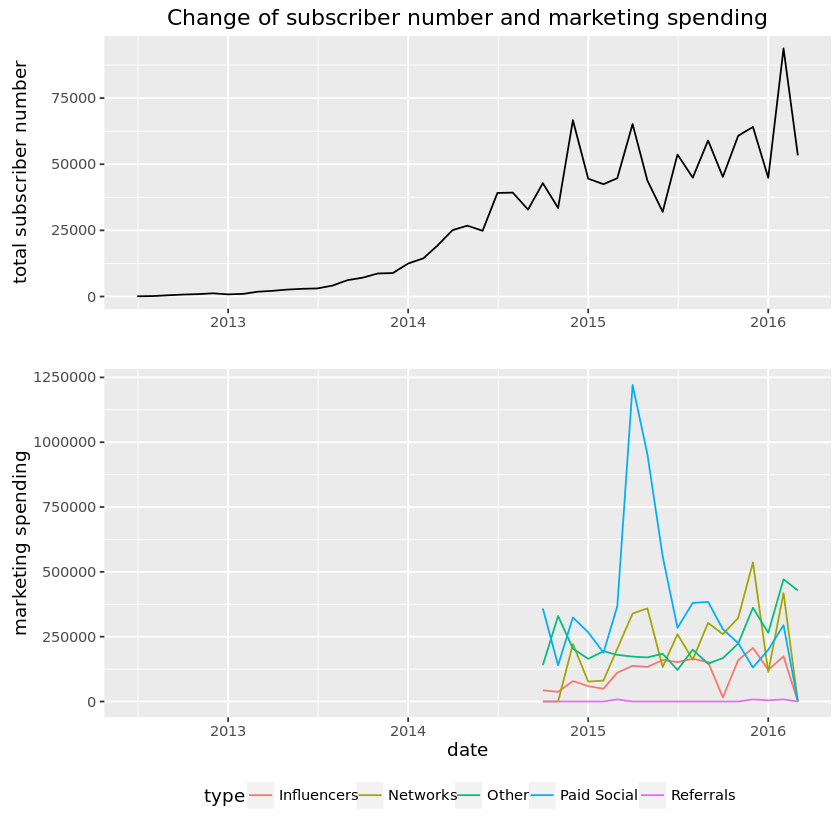

In [21]:
library(gridExtra)
library(grid)

t <- data.frame(date=us$mn[us$mn < min(mkt_channels$date)])
tt <- merge(t, mkt_channels, all = TRUE)

mkt_reorg <- tt %>% gather(type, spend, Influencers:Referrals)

p1 <- ggplot(us, aes(x = mn, y = all)) +
    geom_line() +
    xlab("") + 
    ylab("total subscriber number") +
    ggtitle("Change of subscriber number and marketing spending")
    
p2 <- ggplot(mkt_reorg, aes(x = date, y = spend, color = type)) + 
    geom_line() + 
    scale_fill_continuous(guide = guide_legend()) +
    ylab("marketing spending") + 
    theme(legend.position="bottom")

p1 <- ggplot_gtable(ggplot_build(p1))
p2 <- ggplot_gtable(ggplot_build(p2))

maxWidth = unit.pmax(p1$widths[2:3], p2$widths[2:3])
p1$widths[2:3] <- maxWidth
p2$widths[2:3] <- maxWidth

grid.arrange(p1, p2, heights = c(3, 4))

In [22]:
mkt_channels$'Paid Social'[mkt_channels$'Paid Social'>8e5] <- mean(mkt_channels$'Paid Social')

In [23]:
perc_error <- function(pred, obse){
    pred - obse    
    l <- list(absolute = mean(abs(foc$mean-rec_test)/rec_test), original = mean((foc$mean-rec_test)/rec_test))
return(l)
}

Errors of model prediction can be measured by mean absolute percent error (MAPE) and/or mean percent error (MPE), defined as:

$MAPE = \frac{1}{n}\sum^{n}_{t=1}|\frac{A_t-F_t}{A_t}|$

and 

$MAP = \frac{1}{n}\sum^{n}_{t=1}\frac{A_t-F_t}{A_t}$

MAPE measures the mean accuracy of forecast, while MAP indicates the systematic bias of the forecast

In a [previous post](https://app.datascience.com/insights/preliminary-forecasts-of-subscription-growth-f5i2b9), we explored the usage of exponential smoothing in predicting the growth of subscribers. In this post, we started with an autoregressive integrated moving average (ARIMA(0,1,0)) model, with only the historical data. This results in a model based only on historical trend. For the 18 months of data we have, we used 12 as the training period and 6 as the validation period. The mean absolute percent error of this model is 20.1.

Because marketing is one important driver for subscription growth, we then include the total marketing spending as the external regressor. The resulting model has a MAPE of 13.4 and MPE of -6.37.

| **Model** | **MAPE** |
|-----------|----------|
| Exponential Smoothing | 16 |
|ARIMA(0,1,0) | 20.1 |
|ARIMA(0,1,0) with marketing spending |13.4|

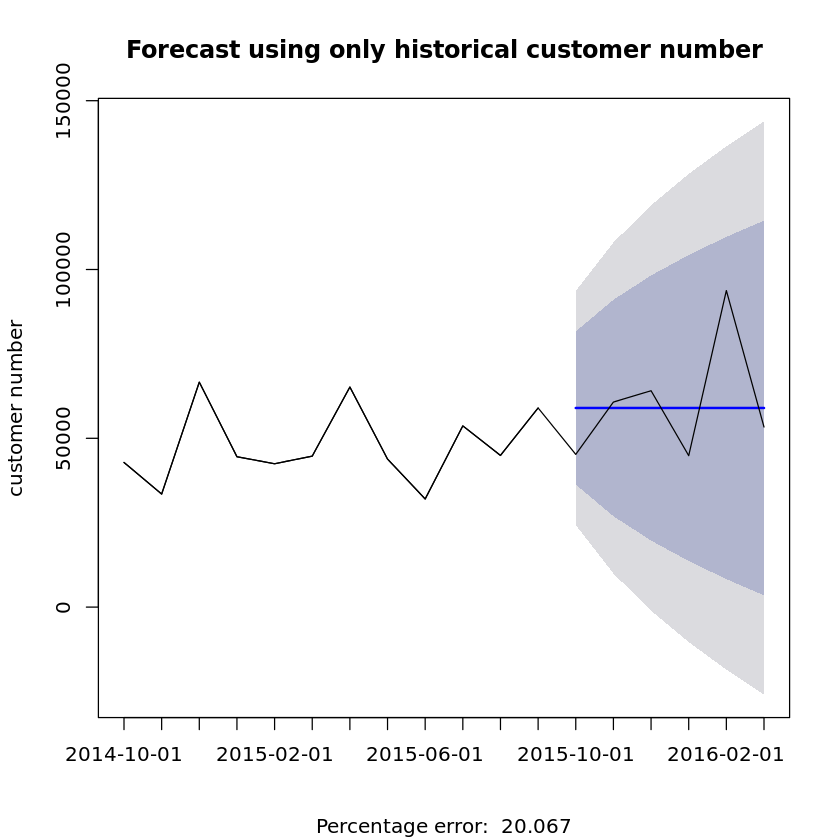

In [24]:
head <- 1
cut <- 12

rec <- us[us$mn>=min(mkt_channels$date)&us$mn<=max(mkt_channels$date),]$all
end <- length(rec)

rec_train <- rec[head:cut]
rec_test <- rec[(cut+1):end]

#fit <- auto.arima(ts(rec_train, frequency = 12), stepwise = F, approximation = F)
fit <- Arima(ts(rec_train, frequency = 12), order=c(0,1,0))
foc <- forecast(fit, h = 6)
err = perc_error(foc$mean, rec_test)
plot(foc, xaxt='n', ann=FALSE)
lines(ts(rec, frequency = 12))

axis(1, at=seq(1,2.5,length=19)[1:18], labels=mkt_channels$date)
title(main="Forecast using only historical customer number",sub=paste("Percentage error: ", sprintf("%.3f", err$absolute*100), collapse=""))
mtext("customer number", side = 2, line=3)

In [25]:
cov <- rowSums(mkt_channels[colnames(mkt_channels)[-1]])
cov_train <- cov[head:cut]
cov_test <- cov[(cut+1):end]

#fit <- auto.arima(ts(rec_train, frequency = 12), stepwise = F, approximation = F, xreg=cov_train)
fit <- Arima(ts(rec_train, frequency = 12), xreg=cov_train, order=c(0,1,0))
foc <- forecast(fit, xreg = cov_test, h = 6)
perc_error(foc$mean, rec_test)

foc_df = data.frame(date = mkt_channels$date,
                      data = rec,
                      forecast = c(rep(NA, length(rec_train)), foc$mean),
                      lower_80 = c(rep(NA, length(rec_train)), foc$lower[,1]),
                      upper_80 = c(rep(NA, length(rec_train)), foc$upper[,1])
                    )

$absolute
[1] 0.1337727

$original
[1] -0.06379963

Given the data we have so far (18 month of monthly resolution total marketing spending), the model we built aims at predicting number of new subscriptions on a monthly level, using marketing spending plan. 

Currently the main challenge and drawback of the model is the low granularity of the marketing spending data, which is limited to 18 month, monthly resolution and global total spending. Results presented are a baseline for accuracy that we will continue to work on improving. One big step towards improvement would be having more detailed data on marketing spending, especially at a finer temporal resolution, as the respond time of marketing campaign could be less than 1 week.

Warning message:
: Removed 12 rows containing missing values (geom_path).Warning message:
: Removed 12 rows containing missing values (geom_ribbon).

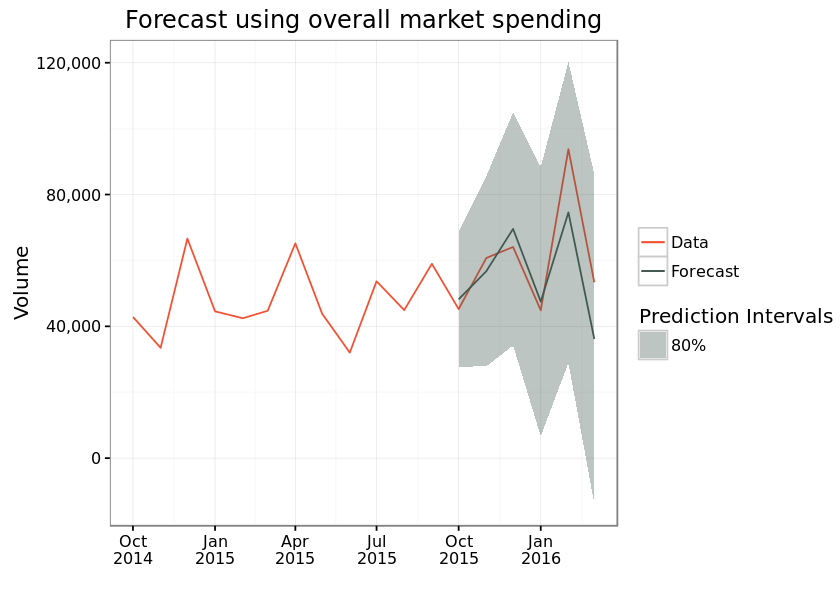

In [31]:
ggplot_forecast_plot(foc_df, "Forecast using overall market spending")

# plot(foc, xaxt='n', ann=FALSE)
# lines(ts(rec, frequency = 12))

# axis(1, at=seq(1,2.5,length=19)[1:18], labels=mkt_channels$date)
# title(main="Forcast using overall market spending",sub=paste("Percentage error: ", sprintf("%.3f", err$absolute), collapse=""))
# mtext("customer number", side = 2, line=3)

The next figure shows the error structure of ARIMA(0,1,0) model with marketing spending. The residuals are normally distributed. The error structure shows that autocorrelation with lag=1 might still exists. When adding the autocorrelation component to the model we only have marginal improvement in the forecast, but also a systematic underestimation and non-normal distributed residuals. Therefore we kept ARIMA(0,1,0) as our forecast model.

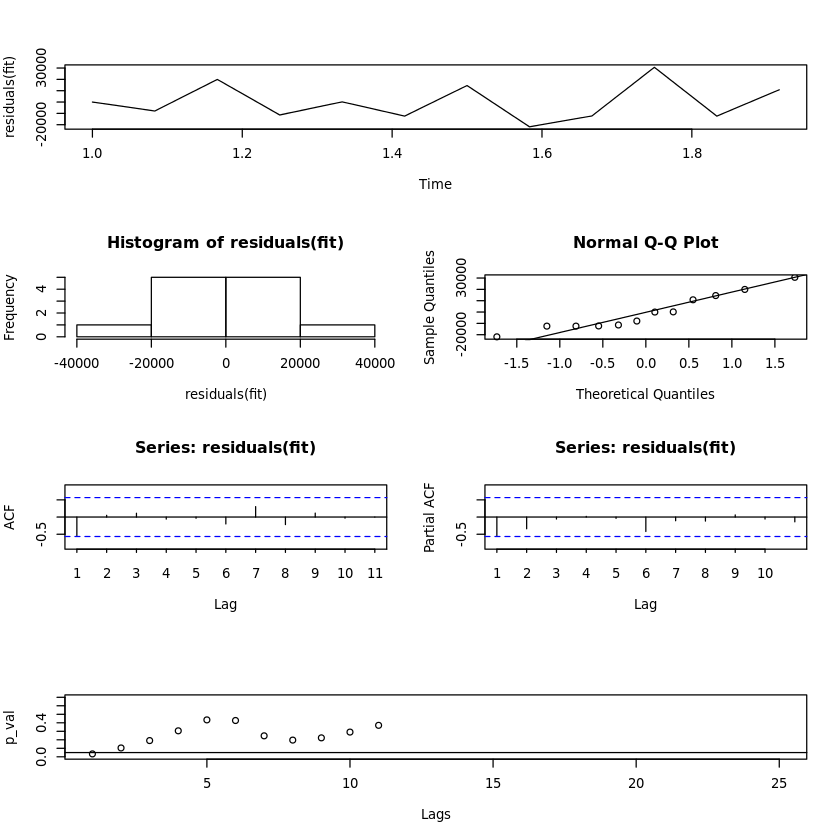

In [27]:
time_series_diagnostic_plots(fit)

### Impact and Further Opportunity

For the first iteration, we achieved 13.4% error rate with ARIMA(0,1,0) model, using marketing spending as the driver. With future plans on marketing spending, we can predict the future growth of subscriber number. To further improve this model, we would use more granular information, such as marketing spending on weekly level, or marketing spending broken down into international and domestic.

In [29]:
head <- 1

rec <- us[us$mn>=min(mkt_channels$date)&us$mn<=max(mkt_channels$date),]$all
cov <- rowSums(mkt_channels[colnames(mkt_channels)[-1]])
end <- length(rec)
results <- c() 

for (cut in seq(12,15)) {
    rec_train <- rec[head:cut]
    rec_test <- rec[(cut+1):end]
    cov_train <- cov[head:cut]
    cov_test <- cov[(cut+1):end]

    # fit <- auto.arima(ts(rec_train, frequency = 12), stepwise = F, approximation = F, xreg=cov_train)
    fit <- Arima(ts(rec_train, frequency = 12), xreg=cov_train, order=c(0,1,0))
    foc <- forecast(fit, xreg = cov_test, h = 18-cut)
    err = perc_error(foc$mean, rec_test) 
    results <- c(results, err$absolute) }

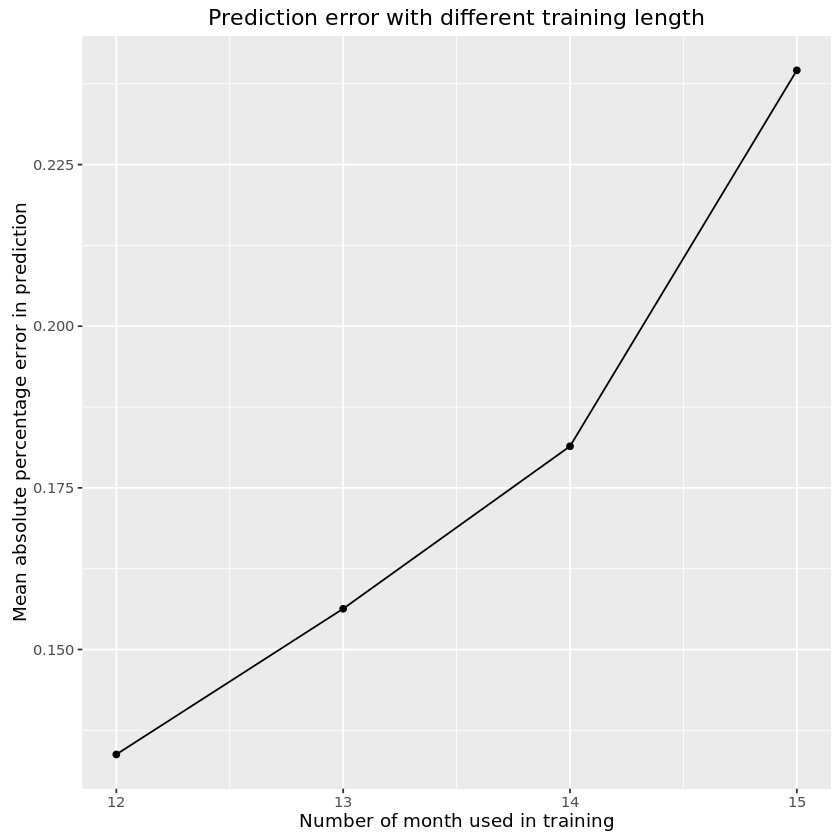

In [30]:
ggplot(data.frame(x=seq(12,15), y=results),  aes(x = x, y = y)) + 
    geom_point() +
    geom_line() +
    xlab("Number of month used in training") + 
    ylab("Mean absolute percentage error in prediction") +
    ggtitle("Prediction error with different training length")